# Student Experiment: Cat vs. Dog Image Classification with CNN
## Overview

Objective: Students will learn image classification by building a Convolutional Neural Network (CNN) to distinguish between cats and dogs.

Environment: Google Colab (GPU recommended).
Libraries: Pillow, TensorFlow/Keras, NumPy, Matplotlib.

# step 0: Import Necessary Libraries

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Step 1: Generate and Visualize Synthetic Images

Task: Generate 100 synthetic images (50 cats, 50 dogs) using Pillow, visualize a few examples, and save them for later use. This step introduces students to synthetic data creation.

Student Tasks:

    Run the code to generate and visualize images.
    Check the generated images in dataset/synthetic/.
    Save images to Google Drive and verify the Drive folder.
    Discuss: How do synthetic cats and dogs differ from real ones? (Simple shapes vs. complex textures)

In [14]:
! pip install pillow

Generating synthetic images...
Generated 50 cat and 50 dog images!


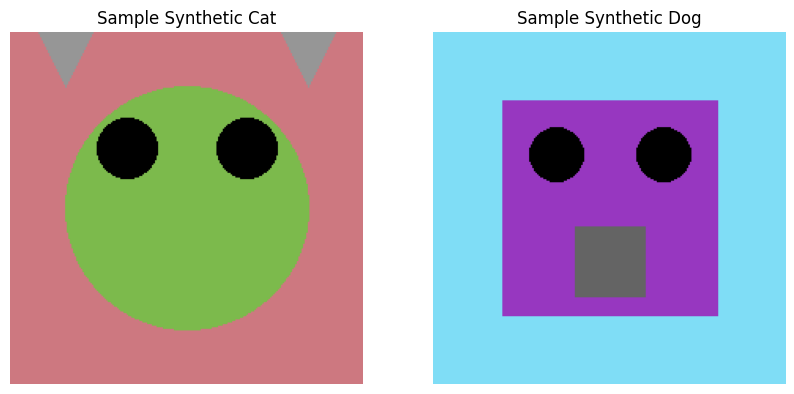

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Synthetic images saved to Google Drive!


In [15]:
from PIL import Image, ImageDraw
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Create directories
os.makedirs('dataset/synthetic/cats', exist_ok=True)
os.makedirs('dataset/synthetic/dogs', exist_ok=True)

# Random background color
def random_background():
    return (random.randint(100, 255), random.randint(100, 255), random.randint(100, 255))

# Generate cat image (circular head, triangular ears, oval eyes)
def generate_cat_image(img_size=(224, 224), idx=0):
    img = Image.new('RGB', img_size, color=random_background())
    draw = ImageDraw.Draw(img)

    # Circular head
    head_size = random.randint(60, 80)
    head_center = (img_size[0]//2, img_size[1]//2)
    draw.ellipse(
        [head_center[0]-head_size, head_center[1]-head_size,
         head_center[0]+head_size, head_center[1]+head_size],
        fill=(random.randint(50, 200), random.randint(50, 200), random.randint(50, 200))
    )

    # Triangular ears
    ear_size = head_size // 2
    draw.polygon(
        [(head_center[0]-head_size, head_center[1]-head_size),
         (head_center[0]-head_size-ear_size, head_center[1]-head_size-ear_size*2),
         (head_center[0]-head_size+ear_size, head_center[1]-head_size-ear_size*2)],
        fill=(150, 150, 150)
    )
    draw.polygon(
        [(head_center[0]+head_size, head_center[1]-head_size),
         (head_center[0]+head_size+ear_size, head_center[1]-head_size-ear_size*2),
         (head_center[0]+head_size-ear_size, head_center[1]-head_size-ear_size*2)],
        fill=(150, 150, 150)
    )

    # Oval eyes
    eye_size = head_size // 4
    draw.ellipse(
        [head_center[0]-head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]-head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )
    draw.ellipse(
        [head_center[0]+head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]+head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )

    img.save(f'dataset/synthetic/cats/cat_{idx}.png')
    return img

# Generate dog image (rectangular head, square nose, circular eyes)
def generate_dog_image(img_size=(224, 224), idx=0):
    img = Image.new('RGB', img_size, color=random_background())
    draw = ImageDraw.Draw(img)

    # Rectangular head
    head_size = random.randint(60, 80)
    head_center = (img_size[0]//2, img_size[1]//2)
    draw.rectangle(
        [head_center[0]-head_size, head_center[1]-head_size,
         head_center[0]+head_size, head_center[1]+head_size],
        fill=(random.randint(50, 200), random.randint(50, 200), random.randint(50, 200))
    )

    # Square nose
    nose_size = head_size // 3
    draw.rectangle(
        [head_center[0]-nose_size, head_center[1]+head_size//2-nose_size,
         head_center[0]+nose_size, head_center[1]+head_size//2+nose_size],
        fill=(100, 100, 100)
    )

    # Circular eyes
    eye_size = head_size // 4
    draw.ellipse(
        [head_center[0]-head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]-head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )
    draw.ellipse(
        [head_center[0]+head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]+head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )

    img.save(f'dataset/synthetic/dogs/dog_{idx}.png')
    return img

# Generate 50 cats and 50 dogs
print("Generating synthetic images...")
cat_images, dog_images = [], []
for i in range(50):
    cat_images.append(generate_cat_image(idx=i))
    dog_images.append(generate_dog_image(idx=i))
print("Generated 50 cat and 50 dog images!")

# Visualize a few examples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_images[0])
plt.title("Sample Synthetic Cat")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(dog_images[0])
plt.title("Sample Synthetic Dog")
plt.axis('off')
plt.show()

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp -r dataset/synthetic /content/drive/MyDrive/synthetic_dataset
print("Synthetic images saved to Google Drive!")

Question: how is the cat and dog picture looks like?



> Don't worry too much, you will learn how to generate cats and dogs that are definitely more realistic than this! This is just to get a feel for it.



## Step 2: pre-processing

Step 2.1: Define Constants

    Define constants for image size (IMG_SIZE = (224, 224)) and batch size (BATCH_SIZE = 32) to standardize input dimensions and training batch processing.

In [ ]:
# Define image size and batch size

Step 2.2: Load and Preprocess the Real Dataset

    Write a function load_real_dataset() to load the cats_vs_dogs dataset from TensorFlow Datasets.
    Split the dataset into 80% training and 20% testing using split=['train[:80%]', 'train[80%:]'].
    Define a preprocessing function to resize images to IMG_SIZE and normalize pixel values to [0,1].
    Apply preprocessing, batching, and prefetching to optimize data loading.

In [ ]:
# 1. Load and preprocess the real dataset (Cats vs Dogs from TensorFlow Datasets)
def load_real_dataset():

    # Load dataset with splits for train and test


    # Preprocess function
    # Normalize to [0,1]
    # Apply preprocessing and batching

# 2. Load and preprocess the synthetic dataset
def load_synthetic_dataset():

    # Load dataset with splits for train and test


    # Preprocess function
    # Normalize to [0,1]
    # Apply preprocessing and batching

# step 3: cnn model

In [ ]:
# 3. Define CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# step 4: Train and evaluate model with epoches 10

In [ ]:
# 4. Train and evaluate model
def train_and_evaluate(model, train_data, val_data, dataset_name, epochs=10):

    # Evaluate on validation set

    # Plot training history


    return history, val_accuracy

step 5:

In [ ]:
# 5. Main execution
if __name__ == "__main__":
    # Load datasets


    # Create and train model on real dataset

    # Create and train model on synthetic dataset

    # Compare performance

    # Visualize comparison using a bar chart


    # Save models to Google Drive, optional


Question: how is the results? what's the difference from real and synthetic dataset?

Loading real Cats vs Dogs dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.D6UTMA_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Loading synthetic dataset...
Found 24000 images belonging to 3 classes.
Found 6000 images belonging to 3 classes.

Training on Real Dataset dataset...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.5992 - loss: 0.6844 - val_accuracy: 0.7268 - val_loss: 0.5353
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7382 - loss: 0.5204 - val_accuracy: 0.7779 - val_loss: 0.4688
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8015 - loss: 0.4270 - val_accuracy: 0.7941 - val_loss: 0.4464
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8480 - loss: 0.3523 - val_accuracy: 0.8057 - val_loss: 0.4454
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8939 - loss: 0.2613 - val_accuracy: 0.8005 - val_loss: 0.5008
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9265 - loss: 0.1912 - val_accuracy: 0.7969 - val_loss: 0.5495
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9441 - loss: 0.1433 - val_accuracy: 0.7919 - val_loss: 0.6542
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9614 - loss: 0.1036 - val_accuracy: 0.80

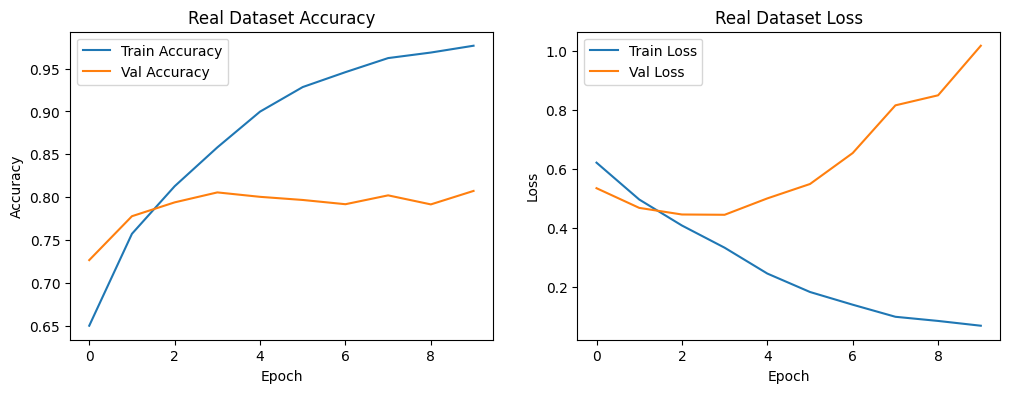


Training on Synthetic Dataset dataset...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.1712 - loss: -2199949672448.0000 - val_accuracy: 0.1667 - val_loss: -92201086353408.0000
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.1671 - loss: -360102204801024.0000 - val_accuracy: 0.1667 - val_loss: -2556846913093632.0000
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.1617 - loss: -4601612391677952.0000 - val_accuracy: 0.1667 - val_loss: -15315270335725568.0000
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.1663 - loss: -21645020264136704.0000 - val_accuracy: 0.1667 - val_loss: -50917455769370624.0000
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.1673 - loss: -63591414633594880.0000 - val_accuracy: 0.1667 - val_loss: -125795760989011968.0000
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.1655 - loss: -150365241664864256.0000 - val_accuracy: 0.1667 - val_loss: -256873953794981888.0000
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━

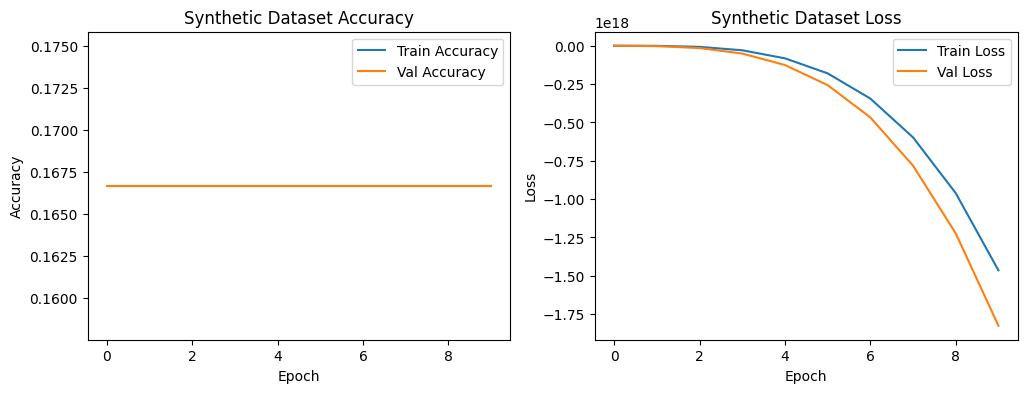


Performance Comparison:
Real Dataset Validation Accuracy: 0.8074
Synthetic Dataset Validation Accuracy: 0.1667


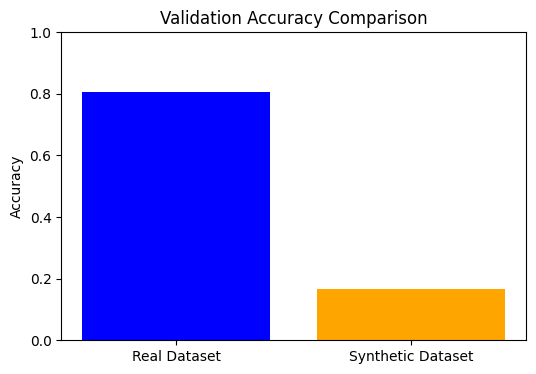

Mounted at /content/drive


Models saved to Google Drive!


In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Load and preprocess the real dataset (Cats vs Dogs from TensorFlow Datasets)
def load_real_dataset():
    print("Loading real Cats vs Dogs dataset...")
    # Load dataset with splits for train and test
    (ds_train, ds_test), ds_info = tfds.load(
        'cats_vs_dogs',
        split=['train[:80%]', 'train[80%:]'],
        as_supervised=True,
        with_info=True
    )

    # Preprocess function
    def preprocess(image, label):
        image = tf.image.resize(image, IMG_SIZE)
        image = image / 255.0  # Normalize to [0,1]
        return image, label

    # Apply preprocessing and batching
    ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds_train, ds_test, ds_info

# 2. Load and preprocess the synthetic dataset
def load_synthetic_dataset():
    print("Loading synthetic dataset...")
    data_dir = 'dataset/synthetic'
    # Use ImageDataGenerator to load synthetic images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation'
    )
    return train_generator, validation_generator

# 3. Define CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 4. Train and evaluate model
def train_and_evaluate(model, train_data, val_data, dataset_name, epochs=10):
    print(f"\nTraining on {dataset_name} dataset...")
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        verbose=1
    )

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f"{dataset_name} Validation Accuracy: {val_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{dataset_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{dataset_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return history, val_accuracy

# 5. Main execution
if __name__ == "__main__":
    # Load datasets
    real_train, real_test, real_info = load_real_dataset()
    synthetic_train, synthetic_val = load_synthetic_dataset()

    # Create and train model on real dataset
    model_real = create_cnn_model()
    history_real, acc_real = train_and_evaluate(model_real, real_train, real_test, "Real Dataset")

    # Create and train model on synthetic dataset
    model_synthetic = create_cnn_model()
    history_synthetic, acc_synthetic = train_and_evaluate(model_synthetic, synthetic_train, synthetic_val, "Synthetic Dataset")

    # Compare performance
    print("\nPerformance Comparison:")
    print(f"Real Dataset Validation Accuracy: {acc_real:.4f}")
    print(f"Synthetic Dataset Validation Accuracy: {acc_synthetic:.4f}")

    # Visualize comparison using a bar chart
    datasets = ['Real Dataset', 'Synthetic Dataset']
    accuracies = [acc_real, acc_synthetic]

    plt.figure(figsize=(6, 4))
    plt.bar(datasets, accuracies, color=['blue', 'orange'])
    plt.title('Validation Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    # Save models to Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    model_real.save('/content/drive/MyDrive/synthetic_dataset/real_cnn_model.h5')
    model_synthetic.save('/content/drive/MyDrive/synthetic_dataset/synthetic_cnn_model.h5')
    print("Models saved to Google Drive!")